Epoch 001: Train Loss = 2.152164, Test Loss = 2.202545
Epoch 002: Train Loss = 2.118183, Test Loss = 2.146074
Epoch 003: Train Loss = 2.047023, Test Loss = 2.003289
Epoch 004: Train Loss = 1.812045, Test Loss = 1.559354
Epoch 005: Train Loss = 1.357548, Test Loss = 1.100132
Epoch 006: Train Loss = 0.929991, Test Loss = 0.696823
Epoch 007: Train Loss = 0.612589, Test Loss = 0.432885
Epoch 008: Train Loss = 0.408514, Test Loss = 0.302740
Epoch 009: Train Loss = 0.317225, Test Loss = 0.277244
Epoch 010: Train Loss = 0.290272, Test Loss = 0.249416
Epoch 011: Train Loss = 0.270855, Test Loss = 0.235477
Epoch 012: Train Loss = 0.260975, Test Loss = 0.227298
Epoch 013: Train Loss = 0.251235, Test Loss = 0.226483
Epoch 014: Train Loss = 0.244896, Test Loss = 0.224861
Epoch 015: Train Loss = 0.238987, Test Loss = 0.218397
Epoch 016: Train Loss = 0.232975, Test Loss = 0.212160
Epoch 017: Train Loss = 0.228205, Test Loss = 0.208765
Epoch 018: Train Loss = 0.224336, Test Loss = 0.205993
Epoch 019:

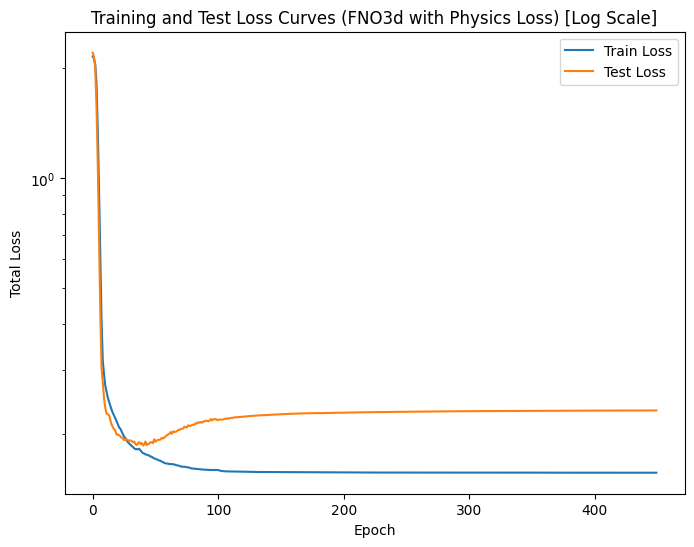

Starting L-BFGS fine-tuning...
L-BFGS Epoch 001: Loss = 0.156691
L-BFGS Epoch 002: Loss = 0.156690
L-BFGS Epoch 003: Loss = 0.156690
L-BFGS Epoch 004: Loss = 0.156690
L-BFGS Epoch 005: Loss = 0.156690
L-BFGS Epoch 006: Loss = 0.156689
L-BFGS Epoch 007: Loss = 0.156689
L-BFGS Epoch 008: Loss = 0.156689
L-BFGS Epoch 009: Loss = 0.156689
L-BFGS Epoch 010: Loss = 0.156688
L-BFGS Epoch 011: Loss = 0.156688
L-BFGS Epoch 012: Loss = 0.156688
L-BFGS Epoch 013: Loss = 0.156688
L-BFGS Epoch 014: Loss = 0.156687
L-BFGS Epoch 015: Loss = 0.156687
L-BFGS Epoch 016: Loss = 0.156687
L-BFGS Epoch 017: Loss = 0.156686
L-BFGS Epoch 018: Loss = 0.156686
L-BFGS Epoch 019: Loss = 0.156686
L-BFGS Epoch 020: Loss = 0.156686
L-BFGS Epoch 021: Loss = 0.156686
L-BFGS Epoch 022: Loss = 0.156685
L-BFGS Epoch 023: Loss = 0.156685
L-BFGS Epoch 024: Loss = 0.156685
L-BFGS Epoch 025: Loss = 0.156685
L-BFGS Epoch 026: Loss = 0.156685
L-BFGS Epoch 027: Loss = 0.156685
L-BFGS Epoch 028: Loss = 0.156684
L-BFGS Epoch 029:

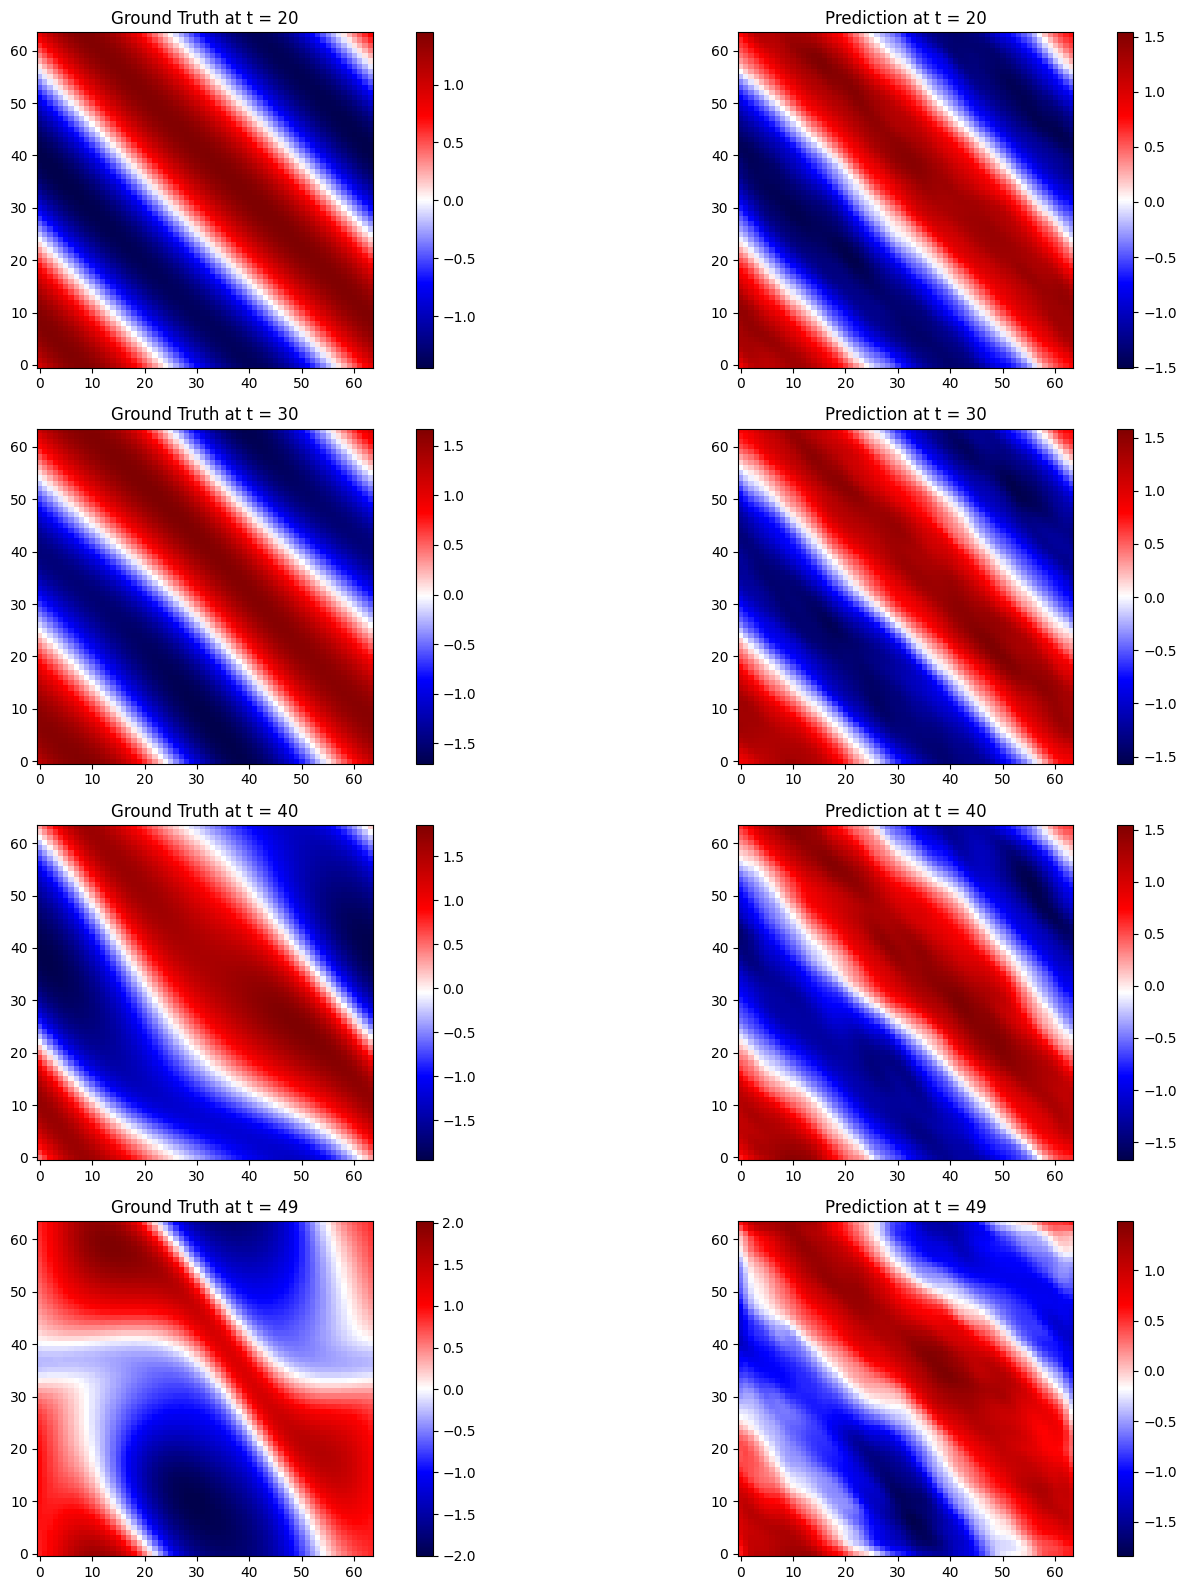

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# =============================================================================
# 1. Navier–Stokes PDE solver (pseudo-spectral method)
# =============================================================================
def solve_navier_stokes(w0, nu, dt, t_final, N):
    """
    Solves the 2D Navier–Stokes vorticity PDE with periodic boundary conditions
    using a pseudo-spectral method.
    
    PDE:
        ∂ₜw + u · ∇w = ν ∆w + f(x)
        u = (ψ_y, -ψ_x) and ∆ψ = -w.
    
    Inputs:
        w0: initial vorticity, shape (N, N)
        nu: viscosity
        dt: time step
        t_final: final time
        N: grid size (N×N)
    Outputs:
        snapshots: list of (t, w) tuples recorded at integer times.
    """
    x = np.linspace(0, 1, N, endpoint=False)
    y = np.linspace(0, 1, N, endpoint=False)
    xv, yv = np.meshgrid(x, y, indexing='ij')
    f = 0.1 * (np.sin(2*np.pi*(xv + yv)) + np.cos(2*np.pi*(xv + yv)))
    kx = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    ky = np.fft.fftfreq(N, d=1.0/N) * 2*np.pi
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    ksq = kx**2 + ky**2
    ksq[0,0] = 1.0  # avoid division by zero
    w = w0.copy()
    snapshots = []
    snapshot_times = np.arange(0, t_final+dt, 1.0)
    next_snapshot_index = 0
    nsteps = int(t_final/dt)
    for step in range(nsteps):
        t = step * dt
        if next_snapshot_index < len(snapshot_times) and t >= snapshot_times[next_snapshot_index]:
            snapshots.append((t, w.copy()))
            next_snapshot_index += 1
        w_hat = np.fft.fft2(w)
        psi_hat = -w_hat / ksq
        psi_hat[0,0] = 0.0
        psi = np.real(np.fft.ifft2(psi_hat))
        u = np.real(np.fft.ifft2(1j * ky * psi_hat))
        v = -np.real(np.fft.ifft2(1j * kx * psi_hat))
        w_x = np.real(np.fft.ifft2(1j * kx * w_hat))
        w_y = np.real(np.fft.ifft2(1j * ky * w_hat))
        nonlinear = u * w_x + v * w_y
        lap_w = np.real(np.fft.ifft2(-ksq * w_hat))
        w = w + dt * (-nonlinear + nu * lap_w + f)
    return snapshots

# =============================================================================
# 2. Navier-Stokes Dataset (using the PDE solver)
# =============================================================================
class NavierStokesDatasetFromSolver(Dataset):
    def __init__(self, num_samples, N, dt, t_final, nu, T_in_range, T_out_times):
        """
        num_samples: number of samples.
        N: grid size (N×N).
        dt: time step.
        t_final: final time (e.g., 50).
        nu: viscosity.
        T_in_range: input time range (e.g., (0,10)).
        T_out_times: target times (e.g., [20,30,40,49]).
        """
        self.samples = []
        for i in range(num_samples):
            w0 = np.random.randn(N, N)
            snapshots = solve_navier_stokes(w0, nu, dt, t_final, N)
            input_series = []
            for t, w in snapshots:
                if t >= T_in_range[0] and t <= T_in_range[1]:
                    input_series.append(w)
            input_series = np.array(input_series)  # (T_in, N, N)
            target_series = []
            for t, w in snapshots:
                if t in T_out_times:
                    target_series.append(w)
            target_series = np.array(target_series)  # (T_out, N, N)
            self.samples.append((input_series, target_series))
        x = np.linspace(0, 1, N, endpoint=False)
        y = np.linspace(0, 1, N, endpoint=False)
        xv, yv = np.meshgrid(x, y, indexing='ij')
        self.spatial_coords = np.stack([xv, yv], axis=-1)  # (N, N, 2)
        self.input_times = np.arange(T_in_range[0], T_in_range[1]+1)
        self.target_times = np.array(T_out_times)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_series, target_series = self.samples[idx]
        T_in = input_series.shape[0]
        N = input_series.shape[1]
        input_data = []
        for i, t in enumerate(self.input_times):
            t_field = np.full((N, N, 1), t)
            w_field = input_series[i][:, :, np.newaxis]
            combined = np.concatenate([w_field, t_field, self.spatial_coords], axis=-1)
            input_data.append(combined)
        input_data = np.stack(input_data, axis=0)  # (T_in, N, N, 4)
        if target_series.shape[0] < len(self.target_times):
            pad_len = len(self.target_times) - target_series.shape[0]
            last = target_series[-1:,...]
            pad = np.repeat(last, pad_len, axis=0)
            target_series = np.concatenate([target_series, pad], axis=0)
        target_data = []
        for i in range(target_series.shape[0]):
            target_data.append(target_series[i][:, :, np.newaxis])
        target_data = np.stack(target_data, axis=0)  # (T_out, N, N, 1)
        input_data = torch.tensor(input_data, dtype=torch.float32)
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

# =============================================================================
# 3. FNO Model (3D FNO: Space-Time Operator Learning) with Physics-Informed Loss
# =============================================================================
class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes_t, modes_x, modes_y):
        super(SpectralConv3d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes_t = modes_t
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes_t, modes_x, modes_y, 2)
        )
    
    def compl_mul3d(self, input, weights):
        weight_complex = torch.view_as_complex(weights)
        return torch.einsum("bctxy, cotxy -> botxy", input, weight_complex)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfftn(x, dim=[2,3,4])
        out_ft = torch.zeros(
            batchsize, self.out_channels, x_ft.size(2), x_ft.size(3), x_ft.size(4),
            device=x.device, dtype=torch.cfloat
        )
        t_modes = min(self.modes_t, x_ft.size(2))
        x_modes = min(self.modes_x, x_ft.size(3))
        y_modes = min(self.modes_y, x_ft.size(4))
        out_ft[:, :, :t_modes, :x_modes, :y_modes] = self.compl_mul3d(
            x_ft[:, :, :t_modes, :x_modes, :y_modes],
            self.weights[:, :, :t_modes, :x_modes, :y_modes]
        )
        x = torch.fft.irfftn(out_ft, s=(x.size(2), x.size(3), x.size(4)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes_t, modes_x, modes_y, width, T_in, T_out):
        """
        modes_t, modes_x, modes_y: Fourier modes along time and space.
        width: latent channel dimension.
        T_in: number of input time steps (e.g., 11 for t=0~10)
        T_out: number of output time steps (e.g., 4 for t=15,20,25,30)
        """
        super(FNO3d, self).__init__()
        self.width = width
        self.T_in = T_in
        self.T_out = T_out
        self.fc0 = nn.Linear(4, width)  # input: [vorticity, t, x, y]
        
        self.conv0 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv1 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv2 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        self.conv3 = SpectralConv3d(width, width, modes_t, modes_x, modes_y)
        
        self.w0 = nn.Conv3d(width, width, 1)
        self.w1 = nn.Conv3d(width, width, 1)
        self.w2 = nn.Conv3d(width, width, 1)
        self.w3 = nn.Conv3d(width, width, 1)
        
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)  # output: vorticity
        
        # Temporal predictor: map input time dimension T_in to output time dimension T_out per pixel
        self.temporal_fc = nn.Linear(T_in, T_out)
        
    def forward(self, x):
        # x: (batch, T_in, H, W, 4)
        batch, T_in, H, W, _ = x.shape
        x = self.fc0(x)  # (batch, T_in, H, W, width)
        x = x.permute(0, 4, 1, 2, 3)  # (batch, width, T_in, H, W)
        
        x0 = self.conv0(x)
        x1 = self.w0(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv1(x)
        x1 = self.w1(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv2(x)
        x1 = self.w2(x)
        x = F.gelu(x0 + x1)
        
        x0 = self.conv3(x)
        x1 = self.w3(x)
        x = F.gelu(x0 + x1)
        
        x = x.permute(0, 2, 3, 4, 1)  # (batch, T_in, H, W, width)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)  # (batch, T_in, H, W, 1)
        
        # Temporal prediction: map the time dimension from T_in to T_out per pixel
        x = x.squeeze(-1)         # (batch, T_in, H, W)
        x = x.permute(0, 2, 3, 1)   # (batch, H, W, T_in)
        x = self.temporal_fc(x)     # (batch, H, W, T_out)
        x = x.permute(0, 3, 1, 2).unsqueeze(-1)  # (batch, T_out, H, W, 1)
        return x

# =============================================================================
# 4. Physics-Informed Loss Functions using autograd
# =============================================================================
def compute_velocity_torch(w):
    """
    Computes velocity (u, v) from vorticity w (batch, H, W) using FFT.
    """
    batch, H, W = w.shape
    device = w.device
    kx = torch.fft.fftfreq(H, d=1.0/H).to(device) * 2 * np.pi
    ky = torch.fft.fftfreq(W, d=1.0/W).to(device) * 2 * np.pi
    kx, ky = torch.meshgrid(kx, ky, indexing='ij')
    kx = kx.unsqueeze(0)  # (1, H, W)
    ky = ky.unsqueeze(0)  # (1, H, W)
    ksq = kx**2 + ky**2
    ksq[0,0,0] = 1.0
    w_hat = torch.fft.fft2(w)
    psi_hat = -w_hat / ksq
    psi_hat[:,0,0] = 0.0
    u_hat = 1j * ky * psi_hat
    v_hat = -1j * kx * psi_hat
    u = torch.real(torch.fft.ifft2(u_hat))
    v = torch.real(torch.fft.ifft2(v_hat))
    return u, v

def compute_PDE_loss(pred, nu, dt, dx, dy):
    """
    Computes the PDE loss for predicted vorticity.
    pred: (batch, T_out, H, W, 1)
    PDE: ∂ₜw + u·∇w = ν Δw + f(x)
    f(x) = 0.1*( sin(2π(x+y)) + cos(2π(x+y)) )
    Uses finite differences to approximate time and space derivatives.
    """
    batch, T_out, H, W, _ = pred.shape
    pred = pred.squeeze(-1)  # (batch, T_out, H, W)
    device = pred.device
    # Create spatial grid tensors
    x = torch.linspace(0, 1, W, device=device).view(1,1,1,W).expand(batch, T_out, H, W)
    y = torch.linspace(0, 1, H, device=device).view(1,1,H,1).expand(batch, T_out, H, W)
    f_val = 0.1 * (torch.sin(2*np.pi*(x+y)) + torch.cos(2*np.pi*(x+y)))  # (batch, T_out, H, W)
    
    loss_pde = 0.0
    count = 0
    for t in range(T_out-1):
        # Time derivative using forward difference
        w_t = (pred[:, t+1, :, :] - pred[:, t, :, :]) / dt  # (batch, H, W)
        w = pred[:, t, :, :]  # (batch, H, W)
        # Spatial derivatives using periodic finite differences:
        # x-derivative (width direction -> dims=2)
        w_x = (torch.roll(w, shifts=-1, dims=2) - torch.roll(w, shifts=1, dims=2)) / (2*dx)
        # y-derivative (height direction -> dims=1)
        w_y = (torch.roll(w, shifts=-1, dims=1) - torch.roll(w, shifts=1, dims=1)) / (2*dy)
        # Second derivatives for Laplacian
        w_xx = (torch.roll(w, shifts=-1, dims=2) - 2*w + torch.roll(w, shifts=1, dims=2)) / (dx**2)
        w_yy = (torch.roll(w, shifts=-1, dims=1) - 2*w + torch.roll(w, shifts=1, dims=1)) / (dy**2)
        lap = w_xx + w_yy
        u, v = compute_velocity_torch(w)
        adv = u * w_x + v * w_y
        r = w_t + adv - nu * lap - f_val[:, t, :, :]
        loss_pde += torch.mean(r**2)
        count += 1
    return loss_pde / count


def compute_BC_loss(pred):
    """
    Computes the boundary condition loss for predicted vorticity,
    enforcing periodic boundary conditions.
    pred: (batch, T_out, H, W, 1)
    """
    batch, T_out, H, W, _ = pred.shape
    pred = pred.squeeze(-1)
    loss_bc = 0.0
    bc_left = pred[:, :, :, 0]
    bc_right = pred[:, :, :, -1]
    loss_bc += torch.mean((bc_left - bc_right)**2)
    bc_top = pred[:, :, 0, :]
    bc_bottom = pred[:, :, -1, :]
    loss_bc += torch.mean((bc_top - bc_bottom)**2)
    return loss_bc

def compute_IC_loss(pred, ic):
    """
    Computes the initial condition loss.
    pred: (batch, T_out, H, W, 1) - we use the first predicted frame.
    ic: (batch, T_out, H, W, 1) - we assume the first frame is the initial condition.
    """
    return F.mse_loss(pred[:,0,:,:,:], ic[:,0,:,:,:])


# =============================================================================
# 4. Training Loop with Physics-Informed Loss
# =============================================================================
def train_model_3d(model, train_loader, test_loader, epochs=300, lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []
    
    # Spatial grid parameters (assuming domain [0,1] for a 64x64 grid)
    H_grid = 64
    W_grid = 64
    dx = 1.0 / W_grid
    dy = 1.0 / H_grid
    
    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for input_data, target in train_loader:
            # input_data: (batch, T_in, H, W, 4), target: (batch, T_out, H, W, 1)
            input_data = input_data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(input_data)  # (batch, T_out, H, W, 1)
            loss_data = loss_fn(output, target)
            loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
            loss_bc = compute_BC_loss(output)
            loss_ic = compute_IC_loss(output, target)
            loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * input_data.size(0)
        total_loss /= len(train_loader.dataset)
        train_losses.append(total_loss)
        
        model.eval()
        total_loss_test = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss_data = loss_fn(output, target)
                loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
                loss_bc = compute_BC_loss(output)
                loss_ic = compute_IC_loss(output, target)
                loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
                total_loss_test += loss.item() * input_data.size(0)
        total_loss_test /= len(test_loader.dataset)
        test_losses.append(total_loss_test)
        #scheduler.step()
        # 매 epoch마다 train와 test loss 출력
        print(f"Epoch {epoch:03d}: Train Loss = {total_loss:.6f}, Test Loss = {total_loss_test:.6f}")
    
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss")
    plt.yscale('log')
    plt.legend()
    plt.title("Training and Test Loss Curves (FNO3d with Physics Loss) [Log Scale]")
    plt.show()
    
    return train_losses, test_losses


# =============================================================================
# 5. Fine-tuning using L-BFGS optimizer
# =============================================================================
def fine_tune_lbfgs(model, train_loader, test_loader, epochs=50, lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20)
    loss_fn = nn.MSELoss()
    
    H_grid = 64
    W_grid = 64
    dx = 1.0 / W_grid
    dy = 1.0 / H_grid
    
    model.train()
    for epoch in range(1, epochs+1):
        total_loss_train = 0.0
        for input_data, target in train_loader:
            input_data = input_data.to(device)
            target = target.to(device)
            def closure():
                optimizer.zero_grad()
                output = model(input_data)
                loss_data = loss_fn(output, target)
                loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
                loss_bc = compute_BC_loss(output)
                loss_ic = compute_IC_loss(output, target)
                loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
                loss.backward()
                return loss
            loss = optimizer.step(closure)
            total_loss_train += loss.item() * input_data.size(0)
        total_loss_train /= len(train_loader.dataset)
        
        # Evaluate on test set
        model.eval()
        total_loss_test = 0.0
        with torch.no_grad():
            for input_data, target in test_loader:
                input_data = input_data.to(device)
                target = target.to(device)
                output = model(input_data)
                loss_data = loss_fn(output, target)
                loss_pde = compute_PDE_loss(output, nu, dt_out, dx, dy)
                loss_bc = compute_BC_loss(output)
                loss_ic = compute_IC_loss(output, target)
                loss = loss_data + lambda_pde * loss_pde + lambda_bc * loss_bc + lambda_ic * loss_ic
                total_loss_test += loss.item() * input_data.size(0)
        total_loss_test /= len(test_loader.dataset)
        model.train()
        print(f"L-BFGS Epoch {epoch:03d}: Train Loss = {total_loss_train:.6f}, Test Loss = {total_loss_test:.6f}")
    return total_loss_train, total_loss_test


# =============================================================================
# 6. Visualization: Discrete Sample Visualization
# =============================================================================
def visualize_sample_3d(model, test_loader):
    """
    Visualizes a discrete sample of ground truth and prediction.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        input_data, target = next(iter(test_loader))
        input_data = input_data.to(device)
        pred = model(input_data)
    sample_target = target[0].cpu().numpy()  # (T_out, H, W, 1)
    sample_pred = pred[0].cpu().numpy()      # (T_out, H, W, 1)
    times = [20, 30, 40, 49]  # target time labels
    T_out = sample_target.shape[0]
    plt.figure(figsize=(16, 4*T_out))
    for i in range(T_out):
        plt.subplot(T_out, 2, 2*i+1)
        plt.title(f"Ground Truth at t = {times[i]}")
        plt.imshow(sample_target[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
        plt.subplot(T_out, 2, 2*i+2)
        plt.title(f"Prediction at t = {times[i]}")
        plt.imshow(sample_pred[i, :, :, 0], cmap="seismic", origin="lower")
        plt.colorbar()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 8. Full Pipeline Execution
# =============================================================================
if __name__ == '__main__':
    # PDE simulation parameters
    N = 64         # Spatial resolution: 64x64
    dt = 0.005     # Time step (small for stability)
    t_final = 50   # Final time
    nu = 1e-3      # Viscosity
    
    # Dataset time ranges
    T_in_range = (0, 10)          # Input: t=0 ~ 10 (integer snapshots)
    T_out_times = [20, 30, 40, 49] # Target times (example)
    
    num_train = 1000   # Number of training samples
    num_test = 200    # Number of test samples
    
    dataset_solver_train = NavierStokesDatasetFromSolver(num_samples=num_train, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    dataset_solver_test  = NavierStokesDatasetFromSolver(num_samples=num_test, N=N, dt=dt, t_final=t_final, nu=nu, 
                                                          T_in_range=T_in_range, T_out_times=T_out_times)
    
    train_loader = DataLoader(dataset_solver_train, batch_size=2, shuffle=True)
    test_loader = DataLoader(dataset_solver_test, batch_size=2, shuffle=False)
    
    modes_t, modes_x, modes_y = 4, 16, 16
    width = 32
    T_out = len(T_out_times)
    T_in = len(np.arange(T_in_range[0], T_in_range[1]+1))  # e.g., 11
    model = FNO3d(modes_t, modes_x, modes_y, width, T_in, T_out)
    
    # Pre-training with Adam optimizer
    train_losses, test_losses = train_model_3d(model, train_loader, test_loader, epochs=450,
                                               lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0)
    
    # Fine-tuning with L-BFGS optimizer
    print("Starting L-BFGS fine-tuning...")
    fine_tune_lbfgs(model, train_loader, epochs=50, lambda_pde=1.0, lambda_bc=1.0, lambda_ic=1.0, dt_out=1.0)
    
    # Visualize discrete sample frames
    visualize_sample_3d(model, test_loader)
    

